# 年龄检测案例

在接下来的案例中，我们将对照片中的人像进行识别并进行年龄检测。识别图像中的人像使用了MTCNN模型，年龄预测部分使用了SSR模型。

### 准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。

In [ ]:
from modelarts.session import Session
session = Session()
session.download_data(bucket_path="modelarts-labs/notebook/DL_age_prediction/age_prediction.tar.gz", path="./age_prediction.tar.gz")
# 使用tar命令解压资源包
!tar xvf ./age_prediction.tar.gz

准备环境：安装mtcnn

In [1]:
!pip install mtcnn

##### MTCNN
MTCNN 是一种人脸对齐模型，在检测出人脸位置的同时也可以检测出五个人脸关键点：左眼，右眼，鼻子，左边嘴角，右边嘴角。

In [2]:
import numpy as np
from mtcnn.mtcnn import MTCNN as mtcnn
from PIL import Image

img = Image.open("./test_image.jpeg")
img = np.array(img)

detector = mtcnn()
detected = detector.detect_faces(img)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


检测结果为：

In [3]:
detected

[{'box': [291, 80, 153, 225],
  'confidence': 0.9999816417694092,
  'keypoints': {'left_eye': (348, 173),
   'right_eye': (417, 163),
   'nose': (399, 205),
   'mouth_left': (357, 246),
   'mouth_right': (418, 237)}}]

将检测结果绘制在图片上：

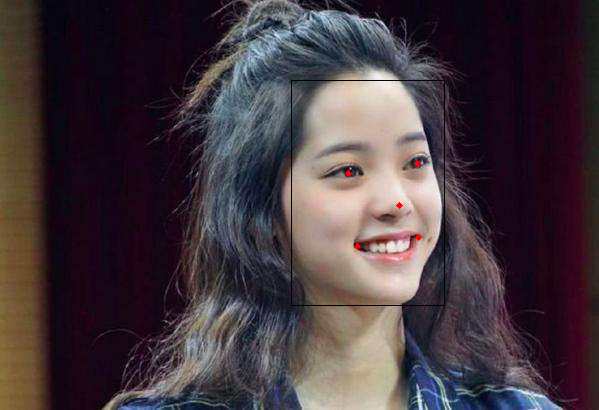

In [4]:
import cv2 

box = detected[0]["box"]
res_img = cv2.rectangle(img, (box[0],box[1]),(box[0]+box[2],box[1]+box[3]), 0, 1)

keypoints = detected[0]["keypoints"]
res_img = cv2.circle(res_img, keypoints['left_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['right_eye'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['nose'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_left'], 1, 255, 4)
res_img = cv2.circle(res_img, keypoints['mouth_right'], 1, 255, 4)

res_img = Image.fromarray(res_img)
res_img

##### SSR 模型

首先我们将模型结构和权重加载，预训练模型位置存储在`weight_file`中。

In [5]:
from SSRNET_model import SSR_net

weight_file = "./model_SSR.h5"

img_size = 64
stage_num = [3,3,3]
lambda_local = 1
lambda_d = 1
model = SSR_net(img_size,stage_num, lambda_local, lambda_d)()
model.load_weights(weight_file)

Using TensorFlow backend.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


模型层级结构

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 62, 62, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 62, 62, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 62, 62, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
batch_norm

准备输入数据

In [7]:
faces = np.empty((len(detected), img_size, img_size, 3))
faces.shape

(1, 64, 64, 3)

将图片的大小进行调整，图片根据人脸检测结果进行裁剪和缩放。

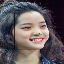

In [9]:
import cv2
ad = 0.4

img_h, img_w, _ = np.shape(img)

for i,d in enumerate(detected):
    if d['confidence'] >=0.95 :
        x1,y1,w,h = d['box']
        x2 = x1 + w
        y2 = y1 + h
        xw1 = max(int(x1 - ad * w), 0)
        yw1 = max(int(y1 - ad * h), 0)
        xw2 = min(int(x2 + ad * w), img_w - 1)
        yw2 = min(int(y2 + ad * h), img_h - 1)
        img = cv2.resize(img[yw1:yw2+1, xw1:xw2+1, :], (img_size, img_size))
        faces[i,:,:,:] = img
        
res_img = Image.fromarray(img)
res_img


将输入数据输入模型，获得预测结果：

In [10]:
res = model.predict(faces)

In [11]:
print("预测年龄为："+str(int(res[0])))

预测年龄为：22
